### *Data Analysis*
##  Plot Prevalence Score and prepare Multivariate Regression for the Speaker Corpus, EU
---
*conducted in May 2022*

In [12]:
from nltk.probability import FreqDist
import statistics
from matplotlib import pyplot
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import math
import os
from matplotlib import cm
from colorspacious import cspace_converter
import docx
import altair as alt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

---
### 1. Prepare prevalence data for descriptives 

In [13]:
expost_eu = pd.read_csv(r"/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/LDA_mallet_eu.csv")
prevalences_eu = pd.read_excel(r"/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_speaking-points/prevalence_scores_eu_spss.xlsx")

In [14]:
expost_eu = expost_eu.drop(columns=['Unnamed: 0', 'level', 'text', 'Document_No', 'Keywords', 'Topic_Perc_Contrib', 'prevalenc_of_topics'])

In [15]:
# Add the prevalences for both topics to prepare for multivariate regression and drop old topics that create confusion
expost_eu.loc[expost_eu['Dominant_Topic'] == 0, ['Dominant_Topic']] = 'AI education'
expost_eu.loc[expost_eu['Dominant_Topic'] == 1, ['Dominant_Topic']] = 'Global market'
expost_eu.loc[expost_eu['Dominant_Topic'] == 2, ['Dominant_Topic']] = 'Digital sovereignty'
expost_eu.loc[expost_eu['Dominant_Topic'] == 3, ['Dominant_Topic']] = 'European technology capacity'
expost_eu.loc[expost_eu['Dominant_Topic'] == 4, ['Dominant_Topic']] = 'Residual'
expost_eu.loc[expost_eu['Dominant_Topic'] == 5, ['Dominant_Topic']] = 'Democracy'
expost_eu.loc[expost_eu['Dominant_Topic'] == 6, ['Dominant_Topic']] = 'Human rights'
expost_eu.loc[expost_eu['Dominant_Topic'] == 7, ['Dominant_Topic']] = 'Residual'
expost_eu

,speaker,gender,member_state,EP,party_group,Dominant_Topic
0,Magdalena Adamowicz,1,Poland,1.0,European People's Party,Democracy
1,Marina Kaljurand,1,Estonia,1.0,Progressive Alliance of Socialists and Democra...,Democracy
2,Annalisa Tardino,1,Italy,1.0,Identity and Democracy Group,Residual
3,Laura Ferrara,1,Italy,1.0,Non-attached Members,Democracy
4,Paulo Rangel,0,Portugal,1.0,European People's Party,Residual
...,...,...,...,...,...,...
168,Geert Bourgeois,0,Belgium,1.0,European Conservatives and Reformists Group,Global market
169,Liesje Schreinemacher,1,Netherlands,1.0,Renew Europe Group,Global market
170,Roman Haider,0,Austria,1.0,Identity and Democracy Group,Residual
171,Anna-Michelle Asimakopoulou,1,Greece,1.0,European People's Party,Global market


In [16]:
expost_eu["prev_ai_edu"] = prevalences_eu["prev_ai-edu"]
expost_eu["AI_education"] = prevalences_eu["AI education"]
expost_eu["prev_global_market"] = prevalences_eu["prev_global-market"]
expost_eu["Global_market"] = prevalences_eu["Global market"]
expost_eu["prev_digital_sov"] = prevalences_eu["prev_digital_sov"]
expost_eu["Digital_sovereignty"] = prevalences_eu["Digital sovereignty"]
expost_eu["prev_eu_tech"] = prevalences_eu["prev_eu-tech-capacity"]
expost_eu["European_technology_capacity"] = prevalences_eu["European technology capacity"]
expost_eu["prev_democracy"] = prevalences_eu["prev_democracy"]
expost_eu["Democracy"] = prevalences_eu["Democracy"]
expost_eu["prev_human_rights"] = prevalences_eu["prev_human-rights"]
expost_eu["Human_rights"] = prevalences_eu["Human rights"]
expost_eu["prev_residual"] = prevalences_eu["prev_residual2"] + prevalences_eu["prev_residual3"]
expost_eu["Residuals"] = expost_eu["prev_residual"]*100

---
#### 1.2 Calculate the mean prevalence scores

In [17]:
# Calculating the mean prevalence scores for each topic
mean_ai_edu = expost_eu["AI_education"].mean()
mean_global_market = expost_eu["Global_market"].mean()
mean_democracy = expost_eu["Democracy"].mean()
mean_digital_sov = expost_eu["Digital_sovereignty"].mean()
mean_human_rights = expost_eu["Human_rights"].mean()
mean_eu_tech_capacity = expost_eu["European_technology_capacity"].mean()
mean_residual = expost_eu["Residuals"].mean()


In [18]:
# initialize data of lists.
means = {'topic':['AI_education', 'Global_market', 'Democracy', 'Digital_sovereignty', 'Human_rights', 'European_technology_capacity', 'Residuals'],
        'mean':[mean_ai_edu, mean_global_market, mean_democracy, mean_digital_sov, mean_human_rights, mean_eu_tech_capacity, mean_residual]}
 
# Create DataFrame
means = pd.DataFrame(means)

In [19]:
means

,topic,mean
0,AI_education,11.795995
1,Global_market,12.287625
2,Democracy,13.626775
3,Digital_sovereignty,12.433001
4,Human_rights,11.930461
5,European_technology_capacity,12.853451
6,Residuals,25.072691


---
### 2. Collect descriptives and visualise

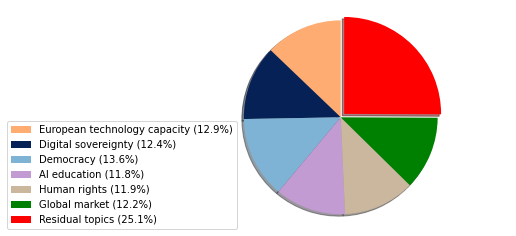

In [20]:
# Pie chart to plot distribution
labels = 'European technology capacity (12.9%)', 'Digital sovereignty (12.4%)', 'Democracy (13.6%)', 'AI education (11.8%)', 'Human rights (11.9%)', 'Global market (12.2%)', 'Residual topics (25.1%)' 
sizes = [12.853451, 12.433001, 13.626775,11.795995, 11.930461, 12.287625, 25.072691]
explode = [0, 0, 0, 0, 0, 0, 0.05]
colors = ['#FFAC72', '#052155', '#7FB3D5', '#C39BD3', '#CAB79E', 'green', 'red']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, explode=explode)
plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(0.2, 0.5))
plt.axis('equal')
plt.show()

In [21]:
# Count dominance of topics
expost_eu["Dominant_Topic"].value_counts()

Residual                        34
Democracy                       33
Global market                   25
AI education                    24
European technology capacity    22
Human rights                    19
Digital sovereignty             16
Name: Dominant_Topic, dtype: int64

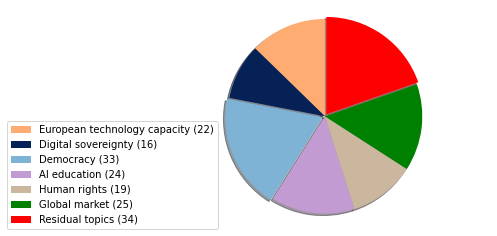

In [22]:
# Create pie chart
labels = 'European technology capacity (22)', 'Digital sovereignty (16)', 'Democracy (33)', 'AI education (24)', 'Human rights (19)', 'Global market (25)', 'Residual topics (34)' 
sizes = [22, 16, 33, 24, 19, 25, 34]
explode = [0, 0, 0.025, 0, 0, 0, 0.025]
colors = ['#FFAC72', '#052155', '#7FB3D5', '#C39BD3', '#CAB79E', 'green', 'red']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, explode=explode)
plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(0.2, 0.5))
plt.axis('equal')
plt.show()

In [23]:
# Save dataframe
means.to_csv('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/prevalence_means-eu.csv')  

---
### 3. Prepare dataframe for multivariate regression in R

In [24]:
# Investigate the states we have and clean up the variable - not necessary here
expost_eu["member_state"].unique()

array(['Poland', 'Estonia', 'Italy', 'Portugal', 'Germany', 'Slovakia',
       'Spain', 'Slovenia', 'Belgium', 'France', 'Cyprus', 'Hungary',
       'Netherlands', 'Romania', 'Greece', 'Latvia', 'Luxembourg',
       'Sweden', 'Denmark', 'Austria', 'Croatia', 'Ireland', 'Czechia',
       'Malta', 'Bulgaria', 'Finland', 'Lithuania'], dtype=object)

In [25]:
expost_eu.to_csv('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/multivariate-reg-data-eu.csv')  